<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=500></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Object detection</b></h2>

### Руководители проекта: 
* Илья Захаркин (Samsung AI Center - Moscow) | tg:@izakharkin
* Юрий Яровиков (AIRI, МФТИ) | tg:@yu_rovikov

<p style="text-align: center;"><img src="https://miro.medium.com/max/750/1*LTPAzUjUentTWoXXmqoT9g.jpeg"></p>

<h2 style="text-align: center;"><b>Этапы работы</b></h2>

<h3 style="text-align: center;"><b>Общий этап работы</b></h3>

# 1). Выбор фреймворка

> Результатом пункта является зафиксированный фреймворк для нейросети-детектора.
**В качестве рабочего фреймворка я выбираю mmdetection**

# 2). Запуск детектора на случайных изображениях

Этот пункт просто про то, чтобы запустить любую модель детектирования в выбранном выше репозитории. Таким образом, часть с запуском будет работать, и далее уже можно приступать к основным сценариям.

> Результатом пункта явлется набор изображений, на которых модель успешно отработала и результат детекции виден и понятен.

In [1]:
import os
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U openmim
!mim install mmcv-full

In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
os.chdir("mmdetection")
!pip install -v -e .

!pip install mmdet==2.24.1

In [5]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmdet
print(mmdet.__version__)

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
from mmcv import Config
from mmdet.apis import set_random_seed
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import auc
from IPython.display import clear_output
import numpy as np
import os
import os.path as osp
import mmcv
import matplotlib
import matplotlib.pyplot as plt
import shutil
import matplotlib.patches as patches
import cv2
import time
import gc
import json
import io

1.12.0+cu113 True
2.25.1


In [17]:
os.makedirs("checkpoints", exist_ok=True)

!mim download mmdet --config mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco --dest ./checkpoints
!mim download mmdet --config ssd300_coco --dest ./checkpoints

processing mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 MiB 8.0 MB/s eta 0:00:00
Successfully downloaded mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth to /content/mmdetection/checkpoints
Successfully dumped mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py to /content/mmdetection/checkpoints
processing ssd300_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 MiB 9.3 MB/s eta 0:00:00
Successfully downloaded ssd300_coco_20210803_015428-d231a06e.pth to /content/mmdetection/checkpoints
Successfully dumped ssd300_coco.py to /content/mmdetection/checkpoints


In [7]:
img = 'demo/demo.jpg'

In [8]:
# Choose to use a config and initialize the detector
config = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')
#inference detector
result = inference_detector(model, img)
#draw results with default function(later will be substituted to my custom function)
show_result_pyplot(model, img, result, score_thr=0.3)

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


load checkpoint from local path: checkpoints/ssd300_coco_20210803_015428-d231a06e.pth


/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


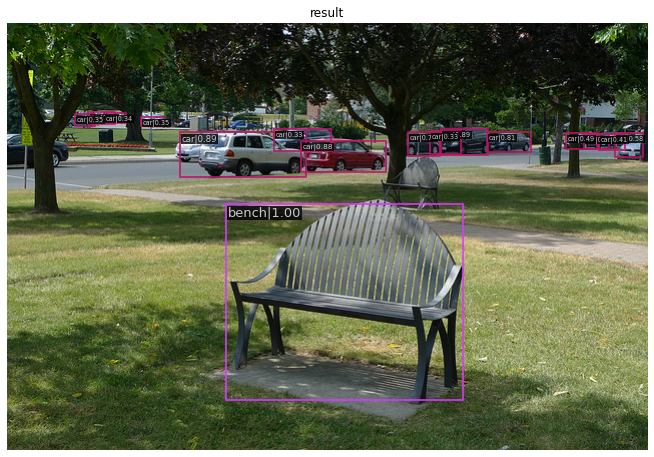

In [18]:
config = 'checkpoints/ssd300_coco.py'
checkpoint = 'checkpoints/ssd300_coco_20210803_015428-d231a06e.pth'

model = init_detector(config, checkpoint, device='cuda:0')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

<font size = 4> В дальнейшем ради скорости работы выберем SSD300

<h3 style="text-align: center;"><b>2 сценарий</b></h3>

Во втором сценарии упор делается на сбор выборки, преобработку данных, обучение модели и измерение качества её работы. То есть осуществляется полный цикл разработки нейросетевой модели для задачи детектирования без встривания в веб/мобильный прототип.

# 3). Выбор датасета

При работе с датасетом вы неизбежно столкнетесь с работой с файлами и папками (директориями). Рекомендуется освежить в памяти работу с библиотеками `os`, `json`, `glob`. Может помочь [этот туториал](https://realpython.com/working-with-files-in-python/).

На выбор предоставляются 5 датасетов по детекции объектов:
1. [Детекция игровых карт](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10): лежат в папке images вместе с разметкой;
2. [Детекция фруктов](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection): скачать можно, нажав на кнопку Download;
3. [Детекция одежды (Deep Fashion 2)](https://github.com/switchablenorms/DeepFashion2): стоит прочитать README на главной странице репозитория. Для получения датасета нужно запросить пароль у автора через гугл-форму. После скачивания распакуйте его с использованием пароля. Из файлов аннотаций нас будут интересовать только `bounding_box`, `category_name` и `category_id`;
4. [Детекция лиц (Wider Face)](http://shuoyang1213.me/WIDERFACE/): большой датасет для детектирования лиц самых разных размеров. Скачать можно прямо по ссылкам на сайте;
5. [Детекция лиц (Kaggle)](https://www.kaggle.com/dataturks/face-detection-in-images): в датасете достаточно мало данных, но можно попробовать, если датасеты выше показались неподходящими для Вас;
6. Датасет из любого соревновани по детекции на Kaggle.

> Результатом выполнения пункта явлется загруженный датасет, состоящий из изображений и разметки к ним (bounding box'ов всех объектов на каждом изображении).
**Будем детектировать наличие касок на рабочих**.
Dataset **Safety helmet detection** из kaggle

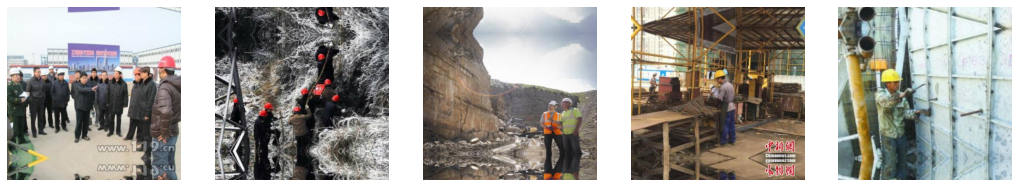

In [19]:
plt.figure(figsize=(18, 8))
for i in range(5):
    img = mmcv.imread("../drive/MyDrive/datasets/archive/images/hard_hat_workers" + str(i) + ".png")
    plt.subplot(1, 5, i + 1)
    plt.imshow(mmcv.bgr2rgb(img))
    plt.axis('off')
plt.show()

# 4). Предобработка данных

Самый непростой этап в этом сценарии. Скачать данные $-$ лишь половина дела. Чтобы обучить нейросеть на этих данных, нужно написать генератор батчей. Однако если будем подавать изображения так, как они есть, то даже батч собрать не сможем -- нужно привести их к однмоу размеру. Далее нужно привести их к типу float, переместить на CUDA и поделить значения в пикселях на 255 (подробнее см. [занятие](https://www.youtube.com/watch?v=XSPYe4-y4HE)). Также нужно настроить аугментации и постобработку.

То, как именно все это реализовать $-$ зависит от инструмента, выбранного в пункте 1. Например, в detectron2 в обучающих материалах описан формат данных для обучения. Возможно, нужно будет зайти в документацию и почитать более подробно, чтобы разобраться, какой именно нужен формат координат.

НЕ нужно копировать все файлы с картинками и разметкой прямо на диске в их предобработанные версии. Хороший тон $-$ осуществлять всю эту обработку программно, "на лету". Поможет [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) по написанию своего датасета на PyTorch.

> Результатом выполнения пункта явлется код, запуск которого ведет к подаче батчей правильного вида (разметка приведена к требуемому формату координат, изображения нужного типа, размера и поделены на 255 и т.д.) для обучения нейронной сети-детектора.

In [20]:
os.makedirs("data")

In [21]:
cp -R ../drive/MyDrive/datasets/archive data

In [22]:
def train_val_test_split(seed=1337, train_size=0.85, val_size=0.1):
    # # Creating Train / Val / Test folders (One time use)
    root_path = 'data/archive'
    im_dir_path = root_path + '/images'
    ann_dir_path = root_path + '/annotations'

    for path in ['/train/images', '/train/annotations',
                 '/val/images', '/val/annotations',
                 '/test/images', '/test/annotations']:
        os.makedirs(root_path + path, exist_ok=True)

    all_im_names = sorted(os.listdir(im_dir_path))
    all_ann_names = sorted(os.listdir(ann_dir_path))
    #create objects in order to shuffle images with corresponding annotations
    objects = np.array([(im, ann) for im, ann in zip(all_im_names, all_ann_names)])
    np.random.seed(seed)
    np.random.shuffle(objects)
    train_obj, val_obj, test_obj = np.split(np.array(objects),
                                            [int(len(objects)*train_size), int(len(objects)*(train_size + val_size))])
    
    #devide images and annotations
    train_im, train_ann = train_obj[:, 0], train_obj[:, 1]
    val_im, val_ann = val_obj[:, 0], val_obj[:, 1]
    test_im, test_ann = test_obj[:, 0], test_obj[:, 1]

    #create absolute pathes to images and annotations
    train_im_path = [im_dir_path + '/' + name for name in train_im]
    train_ann_path = [ann_dir_path + '/' + name for name in train_ann]
    
    val_im_path = [im_dir_path + '/' + name for name in val_im]
    val_ann_path = [ann_dir_path + '/' + name for name in val_ann]
    
    test_im_path = [im_dir_path + '/' + name for name in test_im]
    test_ann_path = [ann_dir_path + '/' + name for name in test_ann]

    print('Total images: ', len(all_im_names))
    print('Training: ', len(train_im_path))
    print('Validation: ', len(val_im_path))
    print('Testing: ', len(test_im_path))

    # Copy-pasting images
    for im, ann in zip(train_im_path, train_ann_path):
        shutil.copy(im, root_path + '/train/images')
        shutil.copy(ann, root_path + '/train/annotations')

    for im, ann in zip(val_im_path, val_ann_path):
        shutil.copy(im, root_path + '/val/images')
        shutil.copy(ann, root_path + '/val/annotations')

    for im, ann in zip(test_im_path, test_ann_path):
        shutil.copy(im, root_path + '/test/images')
        shutil.copy(ann, root_path + '/test/annotations')

In [23]:
train_val_test_split()

Total images:  5000
Training:  4250
Validation:  500
Testing:  250


In [24]:
!rm -r data/archive/images
!rm -r data/archive/annotations

In [ ]:
!git clone https://github.com/roboflow-ai/voc2coco.git

<font size = 4>Создадим файл txt с лейблами</font>

In [26]:
!grep -ERoh '<name>(.*)</name>' data/archive/train | sort | uniq | sed 's/<name>//g' | sed 's/<\/name>//g' > data/archive/train/labels.txt
!grep -ERoh '<name>(.*)</name>' data/archive/val | sort | uniq | sed 's/<name>//g' | sed 's/<\/name>//g' > data/archive/val/labels.txt
!grep -ERoh '<name>(.*)</name>' data/archive/test | sort | uniq | sed 's/<name>//g' | sed 's/<\/name>//g' > data/archive/test/labels.txt

<font size = 4>Создадим txt файл с id</font>

In [27]:
!ls data/archive/train/annotations | sed 's/^/data\/archive\/train\/annotations\//' > data/archive/train/paths.txt
!ls data/archive/val/annotations | sed 's/^/data\/archive\/val\/annotations\//' > data/archive/val/paths.txt
!ls data/archive/test/annotations | sed 's/^/data\/archive\/test\/annotations\//' > data/archive/test/paths.txt

<font size = 4>Конвертируем аннотации VOC в формат COCO</font>

In [28]:
! python voc2coco/voc2coco.py \
    --ann_paths_list data/archive/train/paths.txt \
    --labels data/archive/train/labels.txt \
    --output data/archive/train/output.json \
    --ext xml

! python voc2coco/voc2coco.py \
    --ann_paths_list data/archive/val/paths.txt \
    --labels data/archive/val/labels.txt \
    --output data/archive/val/output.json \
    --ext xml

! python voc2coco/voc2coco.py \
    --ann_paths_list data/archive/test/paths.txt \
    --labels data/archive/test/labels.txt \
    --output data/archive/test/output.json \
    --ext xml

Start converting !
100% 4250/4250 [00:00<00:00, 9698.18it/s]
Start converting !
100% 500/500 [00:00<00:00, 9819.00it/s]
Start converting !
100% 250/250 [00:00<00:00, 7602.45it/s]


In [37]:
model_type = "ssd"

if model_type == "ssd":
  cfg = Config.fromfile('checkpoints/ssd300_coco.py')
elif model_type == "mask_rcnn":
  cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')
CLASSES = ('head', 'helmet', 'person')

## Разбор аугментаций

<font size = 4> Посмотрим часть config файл

```
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Expand',
        mean=[123.675, 116.28, 103.53],
        to_rgb=True,
        ratio_range=(1, 4)),
    dict(
        type='MinIoURandomCrop',
        min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
        min_crop_size=0.3),
    dict(type='Resize', img_scale=(300, 300), keep_ratio=False),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='PhotoMetricDistortion',
        brightness_delta=32,
        contrast_range=(0.5, 1.5),
        saturation_range=(0.5, 1.5),
        hue_delta=18),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[1, 1, 1],
        to_rgb=True),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(300, 300),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=False),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[1, 1, 1],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
```

<font size = 4> Разберём, какие аугментации применяются для изображения.


1.   Expand
<img src = "https://www.telesens.co/wp-content/uploads/2018/06/img_5b35382c10419.png">
2.   Random Crop
<img src = "https://www.telesens.co/wp-content/uploads/2018/06/img_5b35476dbeb90.png">
3. PhotoMetricDistortion


*   Random Brigtness
<img src = "https://www.telesens.co/wp-content/uploads/2018/06/img_5b345fd789997-1024x291.png">
*   Random Contrast, Hue, Saturation
<img src = "https://www.telesens.co/wp-content/uploads/2018/06/img_5b3463b4d93e0.png">
*  Random Lighting Noise
<img src = "https://www.telesens.co/wp-content/uploads/2018/06/img_5b34650f2861b.png">




# 5). Обучение модели-детектора 

Стоит написать цикл обучения на PyTorch самостоятельно, однако допускается использовать [Catalyst](https://github.com/catalyst-team/catalyst), [PyTorch Lightning](https://github.com/williamFalcon/pytorch-lightning) или [Ignite](https://github.com/pytorch/ignite). Например, саму модель можно взять из фреймворка из пункта 1, а обучение осуществлять с помощью одной перечисленных трех библиотек.

> Результатом выполнения пункта явлется код, запуск которого ведет к обучению модели на выбранном датасете. При обучении **обязательно выводить числовые значения лосса на трейне и валидации**, крайне желательно использовать [`TensorBoard`](https://pytorch.org/docs/stable/tensorboard.html) для визуализации. Обязательно также сохранять модель после каждой N-ой эпохи, чтобы потом ее качество можно было проверить и веса были переиспользуемыми.

In [38]:
# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.classes = CLASSES

cfg.data.train.dataset.ann_file = 'data/archive/train/output.json'
cfg.data.train.dataset.img_prefix = 'data/archive/train/images/'
cfg.data.train.dataset.classes=CLASSES

cfg.data.val.ann_file = 'data/archive/val/output.json'
cfg.data.val.img_prefix = 'data/archive/val/images/'
cfg.data.val.classes=CLASSES

cfg.data.test.ann_file = 'data/archive/test/output.json'
cfg.data.test.img_prefix = 'data/archive/test/images/'
cfg.data.test.classes=CLASSES


if model_type == "ssd":
  cfg.model.bbox_head.num_classes = 3
  cfg.load_from = 'checkpoints/ssd300_coco_20210803_015428-d231a06e.pth'
elif model_type == "mask_rcnn":
  cfg.model.roi_head.bbox_head.num_classes = 3
  cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './logs'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.lr_config.warmup = 'linear'
cfg.lr_config.warmup_ratio = 1.0 / 1e10

cfg.log_config.interval = 50
cfg.log_config.hooks.append(dict(type = 'MlflowLoggerHook'))

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
cfg.evaluation.classwise=True
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2

cfg.runner.max_epochs = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    backbone=dict(
        type='SSDVGG',
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://vgg16_caffe')),
    neck=dict(
        type='SSDNeck',
        in_channels=(512, 1024),
        out_channels=(512, 1024, 512, 256, 256, 256),
        level_strides=(2, 2, 1, 1),
        level_paddings=(1, 1, 0, 0),
        l2_norm_scale=20),
    bbox_head=dict(
        type='SSDHead',
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=3,
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            scale_major=False,
            input_size=300,
            basesize_ratio_range=(0.15, 0.9),
            strides=[8, 16, 32, 64, 100, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(


In [39]:
TRAIN = False

datasets = [build_dataset(cfg.data.train)]

model = build_detector(cfg.model)

if TRAIN: 
    # Add an attribute for visualization convenience
    model.CLASSES = datasets[0].CLASSES

    # Create work_dir
    cfg.device = 'cuda'
    mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
    train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


## Пример лог файла

In [10]:
!head -20 ../drive/MyDrive/datasets/saves/output.log

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
2022-07-12 14:20:15,451 - mmdet - INFO - Epoch [1][10/2657]	lr: 4.500e-05, eta: 13:20:16, time: 0.753, data_time: 0.344, memory: 9475, loss_cls: 7.8929, loss_bbox: 2.1723, loss: 10.0652
2022-07-12 14:20:19,147 - mmdet - INFO - Epoch [1][

## Лоссы

<font size = 4>Во время обучению лоссы и метрики выводились на платформе Weights and Biases, встроенную в mmdetection.
    Так как встроенная утилита mmdetection по отображению графиков из логов не работала с kaggle, я вставил графики из Weights and Biases</font>

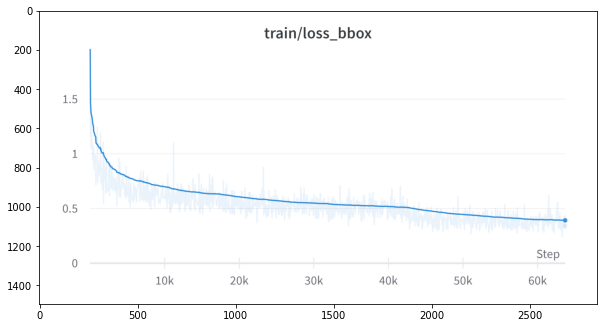

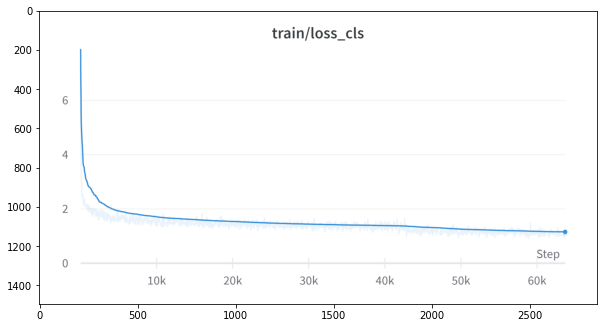

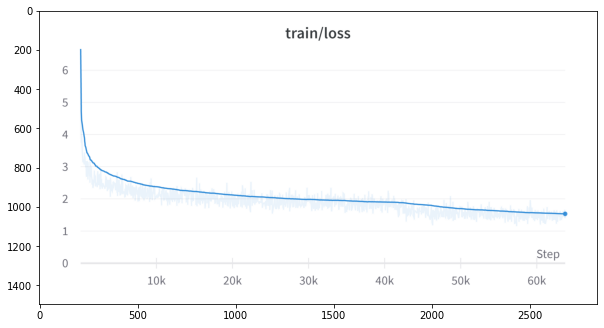

In [41]:
for i, loss_image in enumerate(["../drive/MyDrive/datasets/plots/loss_bbox.png",
                                "../drive/MyDrive/datasets/plots/loss_cls.png",
                                "../drive/MyDrive/datasets/plots/loss.png"]):
    plt.subplots(figsize=(10, 10))
    plt.imshow(plt.imread(loss_image))
plt.show()
    

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread("../drive/MyDrive/datasets/plots/learning_rate.png"))
plt.axis('off')

(-0.5, 2843.5, 1493.5, -0.5)

In [43]:
classes = ['head', 'helmet', 'person']

def show_result(model, uri, score_thr=0.3, figsize=(10, 10), dataset='val', video=False):
    '''
    My custom function to draw bboxes on the image
    '''
    fig, ax = plt.subplots(1, figsize=figsize)
    # Show original, denormalized image...
    #image = inputs[image_idx] / 2 + 0.5
    image = mmcv.imread("data/archive/" + dataset + "/images/" + uri)
    ax.imshow(mmcv.bgr2rgb(image))
    result = inference_detector(model, image)
    # ...with detections
    bboxes = []
    labels = []
    confidences = []

    for label_idx, label in enumerate(classes):
        for bbox_conf in result[label_idx]:
            bboxes.append(list(bbox_conf[:4]))
            labels.append(label)
            confidences.append(bbox_conf[4])

    for bbox_idx, bbox in enumerate(bboxes):
        if confidences[bbox_idx] > score_thr:
            label = labels[bbox_idx]
            left, bot, right, top = bbox
            if label == 'head':
                color = 'r'
            elif label == 'helmet':
                color = 'b'
            else:
                color = 'm'
            x, y, w, h = [val for val in [left, bot, right - left, top - bot]]
            rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none', label=label)
            ax.add_patch(rect)
            ax.text(x+2, y-5, f"{confidences[bbox_idx]*100:.0f}%",
                    bbox=dict(facecolor='w', edgecolor = color), fontsize='8')
    ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left')
    plt.show()
        
                    

## Пример работы на изображениях из тестовой выборки

load checkpoint from local path: ../drive/MyDrive/datasets/saves/latest.pth
hard_hat_workers1807.png


/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


hard_hat_workers2217.png


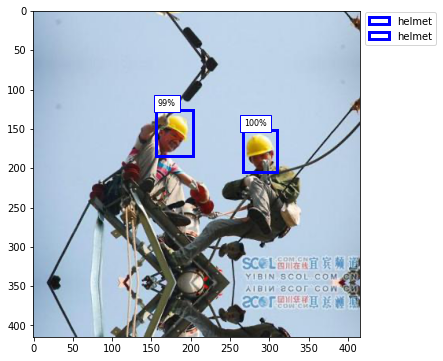

hard_hat_workers4691.png


hard_hat_workers746.png


hard_hat_workers1382.png


hard_hat_workers2316.png


hard_hat_workers4512.png


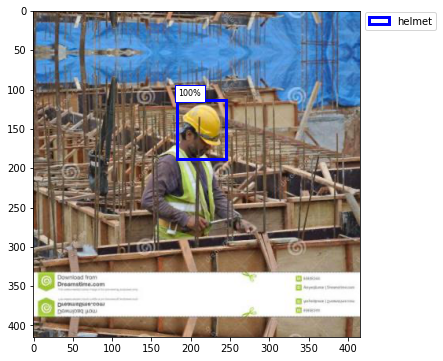

hard_hat_workers2379.png


hard_hat_workers1379.png


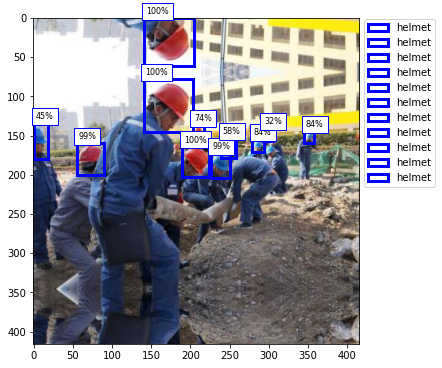

hard_hat_workers2735.png


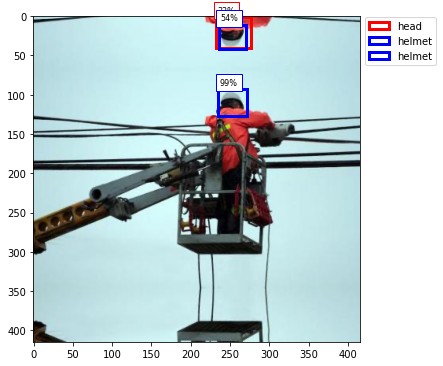

hard_hat_workers1229.png


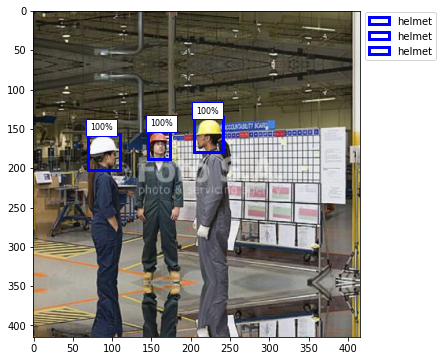

hard_hat_workers1772.png


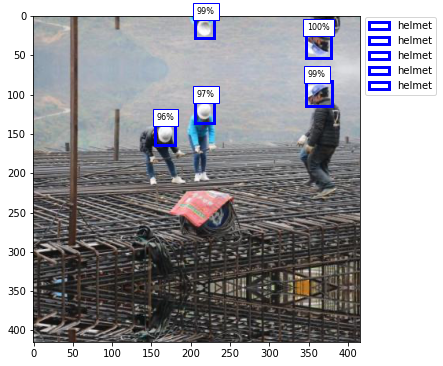

hard_hat_workers578.png


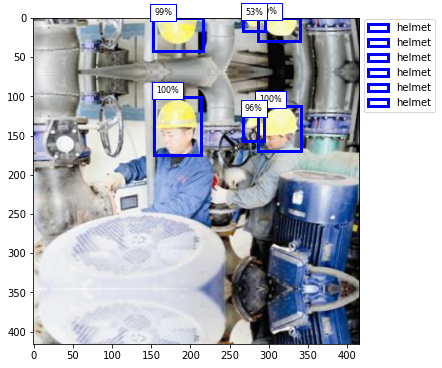

hard_hat_workers1641.png


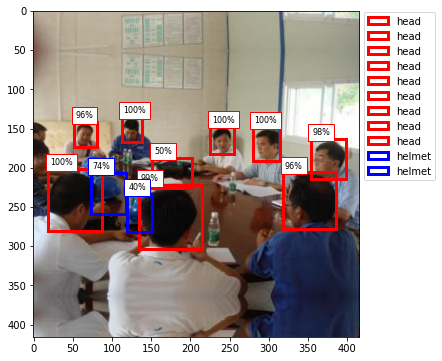

hard_hat_workers1426.png


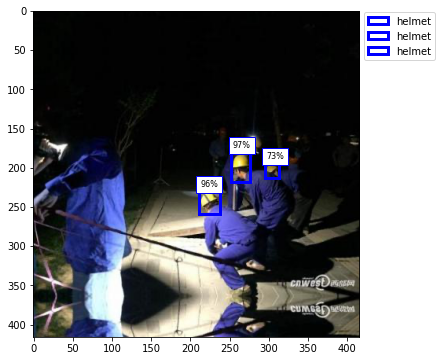

hard_hat_workers3345.png


hard_hat_workers2900.png


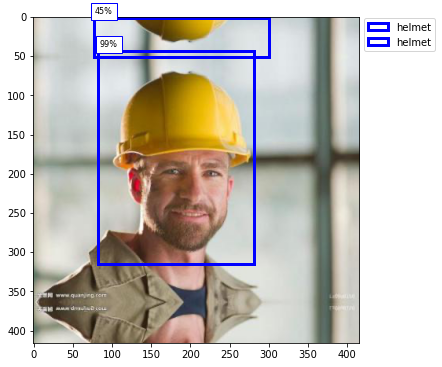

hard_hat_workers2303.png


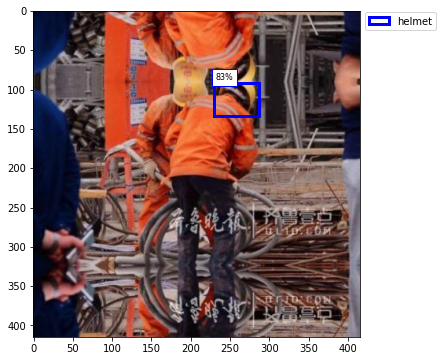

hard_hat_workers3944.png


hard_hat_workers2693.png


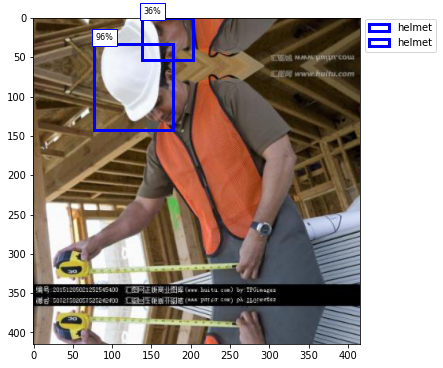

In [45]:
test_uris = os.listdir("data/archive/test/images")[:20]
checkpoint = '../drive/MyDrive/datasets/saves/latest.pth'
model = init_detector(cfg, checkpoint, device='cuda:0')
for uri in test_uris:
    print(uri)
    show_result(model,uri, figsize=(6, 6), dataset='test')

## Детекция видео

In [47]:
classes = ['head', 'helmet', 'person']
def show_result_video(frame, result, width, height, score_thr):
    '''
    My custom function to draw fancy bboxes on video frames using pyplot

    '''
    
    dpi = 140
    fig, ax = plt.subplots(1, figsize=(width/dpi, height/dpi), dpi=dpi)
    ax.imshow(mmcv.bgr2rgb(frame))
    # ...with detections
    bboxes = []
    labels = []
    confidences = []

    for label_idx, label in enumerate(classes):
        for bbox_conf in result[label_idx]:
            bboxes.append(list(bbox_conf[:4]))
            labels.append(label)
            confidences.append(bbox_conf[4])

    for bbox_idx, bbox in enumerate(bboxes):
        if confidences[bbox_idx] > score_thr:
            label = labels[bbox_idx]
            left, bot, right, top = bbox
            if label == 'head':
                color = 'r'
            elif label == 'helmet':
                color = 'b'
            else:
                color = 'm'
            x, y, w, h = [val for val in [left, bot, right - left, top - bot]]
            #print(x, y, w, h)
            rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none', label=label)
            ax.add_patch(rect)
            ax.text(x+10, y+25, f"{confidences[bbox_idx]*100:.0f}%" + label,
                    bbox=dict(facecolor='w', edgecolor = color), fontsize='6')
    fig.tight_layout(pad=0)
    plt.axis('off')
    
    #convert image to array
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi, pad_inches=0)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clear_output()
    return img

In [48]:
def inference_video(model, video, threshhold, save_name='video_demo'):
    cap = mmcv.VideoReader(video)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(save_name + '.mp4', fourcc, cap.fps, (cap.width, cap.height))
    print(f"resolution is {cap.width} x {cap.height}")
    cv2.VideoWriter()
    frame_count = 0 # To count total frames.
    total_fps = 0 # To get the final frames per second.
    for frame in mmcv.track_iter_progress(cap):
        # Increment frame count.
        frame_count += 1
        start_time = time.time()# Forward pass start time.
        result = inference_detector(model, frame)
        end_time = time.time() # Forward pass end time.
        #get fps
        fps = 1 / (end_time - start_time)
        # Add fps to total fps.
        total_fps += fps
        # Write the FPS on the current frame.
        new_frame = show_result_video(frame, result, cap.width, cap.height, threshhold)
        
        cv2.putText(
            new_frame, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 0, 255), 2, cv2.LINE_AA)
        out.write(mmcv.bgr2rgb(new_frame))
        gc.collect()
        del new_frame, result, frame
        
    # Release VideoCapture()
    out.release()
    # Calculate and print the average FPS
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}")
    clear_output()

In [ ]:
checkpoint = '../drive/MyDrive/datasets/saves/latest.pth'
model = init_detector(cfg, checkpoint, device='cuda:0')
inference_video(model, "/content/drive/MyDrive/datasets/energetiki_OkxDxSsv.mp4", 0.3)

**<font size = 7>По [ссылке](https://drive.google.com/file/d/1mk8cF1SfFY-H09nnFIcXbjSSBmBhAuMZ/view?usp=sharing) можно посмотреть на демо. Пожалуйста, посмотрите, я очень старался.</font>**
<font size = 4> FPS, который вы увидите на демо учитывает только время инференса детектора, но не время отрисовки. Дело в том, что дефолтный отрисовщик боксов от mmdetection крайне негибкий и не наглядный, поэтому я переписал его сам на matplotlib. В моём случае время отрисовки занимает приличное количество времени и сильно снижает производительность. Но я решил, что раз проект учебный, упор нужно сделать на красоту визуализации, а скорость отрисовки можно подправить

# 6). Измерение качества работы модели (метрики согласуются с руководителем и зависят от задачи)

Под метриками понимаются функции/формулы, по которым оценивается качество модели-детектора. Обычно для измерения качества работы детектора используют поклассовые Precision, Recall, F1-меру и mean Average Precision (mAP). Подробнее про них можно послушать в [видеолекции 2018 года](https://www.youtube.com/watch?v=ewkSI2cuyoQ&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=24).

Необходимо самостоятельно реализовать функции, вычисляющие поклассовые Precision и Recall. На вход функциям поступают веса модели и выборка, на которой нужно измерить метрики. На выходе $-$ таблица с precision и recall для каждого класса.

> Результат пункта $-$ реализованные функции метрик для задачи детектирования, позволяющие оценить качество работы модели на выборке. Выборка/даталоадер является аргументом функций.

<font size = 4> Для начала посмотрим результаты валидации, которые делал mmdetection во время обучения

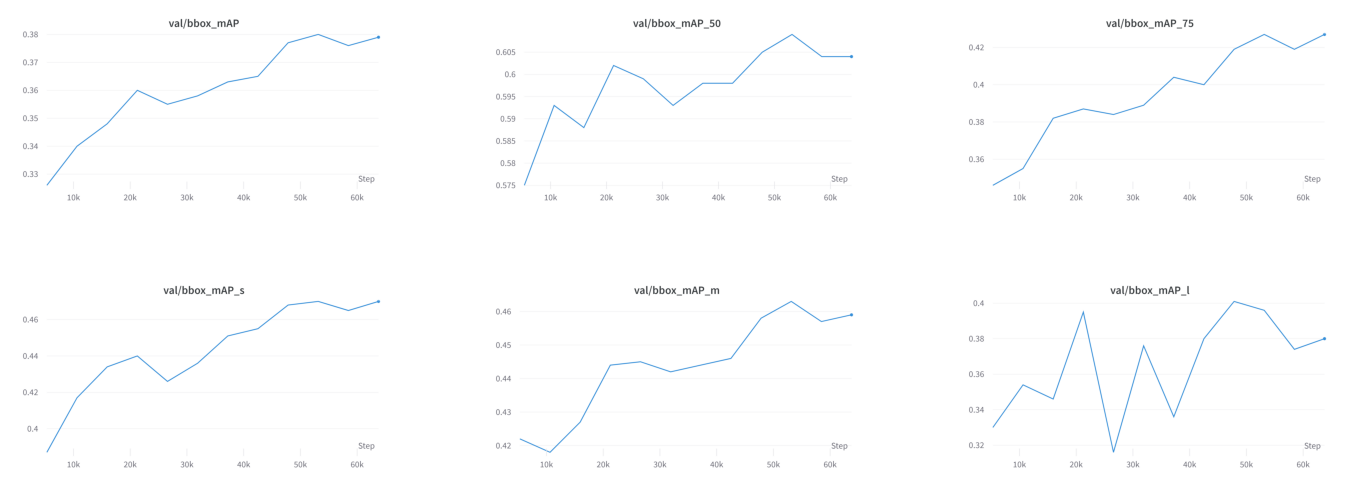

In [49]:
plt.figure(figsize=(24, 9))
for i, map_image in enumerate(["../drive/MyDrive/datasets/plots/val_bbox_mAP.png",
                               "../drive/MyDrive/datasets/plots/val_bbox_mAP_50.png",
                               "../drive/MyDrive/datasets/plots/val_bbox_mAP_75.png",
                               "../drive/MyDrive/datasets/plots/val_bbox_mAP_s.png",
                               "../drive/MyDrive/datasets/plots/val_bbox_mAP_m.png",
                               "../drive/MyDrive/datasets/plots/val_bbox_mAP_l.png"]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(plt.imread(map_image))
    plt.axis('off')
plt.show()

## Подготовительные функции для собственных метрик 

In [50]:
def parse_gt_bboxes(data_ann_path):
    #data_ann_path - coco json file with annotations
    
    with open(data_ann_path, 'r') as f:
      data = json.load(f)

    gt_bboxes_head, gt_bboxes_helmet, gt_bboxes_person = {}, {}, {}

    for gt_bbox in data['annotations']:
        if gt_bbox['category_id'] == 1:
            if gt_bbox['image_id'] not in gt_bboxes_head.keys():
                gt_bboxes_head[gt_bbox['image_id']] = [[*gt_bbox['bbox'], gt_bbox['category_id']]]
            else:
                gt_bboxes_head[gt_bbox['image_id']].append([*gt_bbox['bbox'],gt_bbox['category_id']])

        elif gt_bbox['category_id'] == 2:
            if gt_bbox['image_id'] not in gt_bboxes_helmet.keys():
                gt_bboxes_helmet[gt_bbox['image_id']] = [[*gt_bbox['bbox'], gt_bbox['category_id']]]
            else:
                gt_bboxes_helmet[gt_bbox['image_id']].append([*gt_bbox['bbox'],gt_bbox['category_id']])
        else:
            if gt_bbox['image_id'] not in gt_bboxes_person.keys():
                gt_bboxes_person[gt_bbox['image_id']] = [[*gt_bbox['bbox'], gt_bbox['category_id']]]
            else:
                gt_bboxes_person[gt_bbox['image_id']].append([*gt_bbox['bbox'],gt_bbox['category_id']])
    return gt_bboxes_head, gt_bboxes_helmet, gt_bboxes_person

In [51]:
def parse_pred_bboxes(model, path_to_images, data_ann_path):
    with open(data_ann_path, 'r') as f:
      data = json.load(f)
    
    image_to_id = {}
    for image_dict in data['images']:
        image_to_id[image_dict['file_name']] = image_dict['id']
    
    pred_bboxes_head, pred_bboxes_helmet, pred_bboxes_person = {}, {}, {}
  
    for image_name in os.listdir(path_to_images):
        image = mmcv.imread(path_to_images + "/" + image_name)
        result = inference_detector(model, image)
        image_id = image_to_id[image_name]
        for category_id in range(1, 4):
            result_per_label = result[category_id - 1]
            if category_id == 1:    
                for pred_bbox in result_per_label:
                    if image_id not in pred_bboxes_head.keys():
                        pred_bboxes_head[image_id] = [[*pred_bbox[:4], category_id, pred_bbox[4]]]
                    else:
                        pred_bboxes_head[image_id].append([*pred_bbox[:4], category_id, pred_bbox[4]])
            elif category_id == 2:
                for pred_bbox in result_per_label:
                    if image_id not in pred_bboxes_helmet.keys():
                        pred_bboxes_helmet[image_id] = [[*pred_bbox[:4], category_id, pred_bbox[4]]]
                    else:
                        pred_bboxes_helmet[image_id].append([*pred_bbox[:4], category_id, pred_bbox[4]])
            else:
                for pred_bbox in result_per_label:
                    if image_id not in pred_bboxes_person.keys():
                        pred_bboxes_person[image_id] = [[*pred_bbox[:4], category_id, pred_bbox[4]]]
                    else:
                        pred_bboxes_person[image_id].append([*pred_bbox[:4], category_id, pred_bbox[4]])
    return pred_bboxes_head, pred_bboxes_helmet, pred_bboxes_person

In [52]:
def iou(gt_bbox, pred_bbox):
    '''
    x, y - top left corner
    w, h - weight and height
    '''
    x1, y1, w1, h1 = gt_bbox
    
    left2, top2, right2, bot2 = pred_bbox
    x2, y2, w2, h2 = left2, top2, right2 - left2, bot2 - top2

    intersect_x = max(x1, x2)
    intersect_y = max(y1, y2)
    intersect_width = min(x1 + w1, x2 + w2) - intersect_x
    intersect_height = min(y1 + h1, y2 + h2) - intersect_y
    if intersect_height <= 0 or intersect_width <= 0:
        intersect_square = 0    
    else:
        intersect_square = intersect_width * intersect_height

    union_square = w1 * h1 + w2 * h2 - intersect_square
    
    if union_square != 0:
        return intersect_square / union_square
    else:
        return 0

In [53]:
def conf_matrix(gt_bboxes, pred_bboxes, conf_tresh, iou_tresh=0.5):
    #pred_bbox = [left, top, width, height, label, conf]
    #gt_bbox = [left, top, width, height, label]
    #gt_bboxes = {im1: [bbox1, bbox2, bbox3, ...], im2: [bbox1, bbox2, bbox3, ...], ...}
    #pred_bboxes = {im1: [bbox1, bbox2, bbox3, ...], im2: [bbox1, bbox2, bbox3, ...], ...} 
    
    #count total num of pred_bboxes and filter them by threshold
    pred_bboxes_num_treshed = 0
    pred_bboxes_treshed = {}
    for im_id in pred_bboxes.keys():
        for bbox in pred_bboxes[im_id]:
            if bbox[5] > conf_tresh:
                pred_bboxes_num_treshed += 1
                if im_id not in pred_bboxes_treshed.keys():
                    pred_bboxes_treshed[im_id] = [bbox]
                else:
                    pred_bboxes_treshed[im_id].append(bbox)
    
    #total num of gt_bboxes
    gt_bboxes_num = 0
    for im in gt_bboxes.keys():
        for bbox in gt_bboxes[im]:
            gt_bboxes_num += 1
    
    #calculate pairwise ious
    #ious = {im_id1: {bbox_idx1 : [pair ious], bbox_idx2 : [pair ious] }, im_id2: ...}
    ious = {}
    for im_id, pred_bboxes_per_image in pred_bboxes_treshed.items():
        ious[im_id] = {}
        for pred_bbox_idx, pred_bbox in enumerate(pred_bboxes_per_image):
            ious[im_id][pred_bbox_idx] = []
            if im_id in gt_bboxes.keys():
                for gt_bbox in gt_bboxes[im_id]:
                    ious[im_id][pred_bbox_idx].append(iou(gt_bbox[:4], pred_bbox[:4]))
    
    #calculate conf matrix
    FP = 0
    TP = 0
    for im_id, pred_bboxes_per_image in pred_bboxes_treshed.items():
        for pred_bbox_idx, ious_per_bbox in ious[im_id].items():
            pred_bbox = pred_bboxes_per_image[pred_bbox_idx]
            
            if len(ious_per_bbox) != 0:
                max_iou_gt_bbox_ind = np.argmax(ious_per_bbox)
                max_iou = ious_per_bbox[max_iou_gt_bbox_ind]

                gt_bbox = gt_bboxes[im_id][max_iou_gt_bbox_ind]

                conf = pred_bbox[5]
                if max_iou < iou_tresh:
                    FP += 1
            else:
                FP += 1
                
    TP = pred_bboxes_num_treshed  - FP
    FN = gt_bboxes_num - TP
    return (TP, FP, FN)

## Собственные функции метрик

In [54]:
def precision(conf_matr):
    TP, FP, FN = conf_matr
    return TP / (TP + FP)

def recall(conf_matr):
    TP, FP, FN = conf_matr
    return TP / (TP + FN)

def f1(conf_matr):
    p = precision(conf_matr)
    r = recall(conf_matr)
    return 2 * p * r / (p + r)

In [55]:
def AP(gt_bboxes, pred_bboxes, title, iou_tresh = 0.5, show=True):
    precs = []
    recs = []
    best_f1 = 0
    best_conf = 0
    for conf in tqdm(np.arange(0, 1, 0.01)):
        conf_matr = conf_matrix(gt_bboxes, pred_bboxes, conf_tresh = conf, iou_tresh = iou_tresh)
        precs.append(precision(conf_matr))
        recs.append(recall(conf_matr))
        if f1(conf_matr) > best_f1:
            best_f1 = f1(conf_matr)
            best_conf = conf
    ap = auc(recs, precs)
    best_conf_matr = conf_matrix(gt_bboxes, pred_bboxes, conf_tresh = best_conf, iou_tresh = iou_tresh)
    best_rec = recall(best_conf_matr)
    best_prec = precision(best_conf_matr)
    if show == True:
        plt.figure(figsize=(12, 6))
        plt.plot(recs, precs, c='m')
        plt.scatter(best_rec, best_prec, c='c', s=60, label='best f1')
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title(title)
        plt.legend()
        plt.grid()
        plt.show()
    print(f'best confidence treshhold = {best_conf:.2f}, with precision = {best_prec:.3f}, recall = {best_rec:.3f}, f1 = {best_f1:.3f}')    
    return ap

In [56]:
def evaluate_model(model, path_to_images, data_ann_path, dataset_name, iou_tresh = 0.5, show=True):
    gt_bboxes_head, gt_bboxes_helmet, _ = parse_gt_bboxes(data_ann_path)
    pred_bboxes_head, pred_bboxes_helmet, _ = parse_pred_bboxes(model, path_to_images, data_ann_path)
    
    ap_head = AP(gt_bboxes_head, pred_bboxes_head, 'HEAD', iou_tresh = iou_tresh, show=show)
    ap_helmet = AP(gt_bboxes_helmet, pred_bboxes_helmet, 'HELMET', iou_tresh = iou_tresh, show=show)
    mAP = np.mean([ap_head, ap_helmet])
    print(f'evaluating model on dataset {dataset_name}:')
    print(f'HEAD AP = {ap_head:.3f}')
    print(f'HELMET AP = {ap_helmet:.3f}')
    print(f'mAP = {mAP:.3f}')

### Метрики на val датасете с iou treshhold = 0.5

load checkpoint from local path: ../drive/MyDrive/datasets/saves/latest.pth


  0%|          | 0/100 [00:00<?, ?it/s]

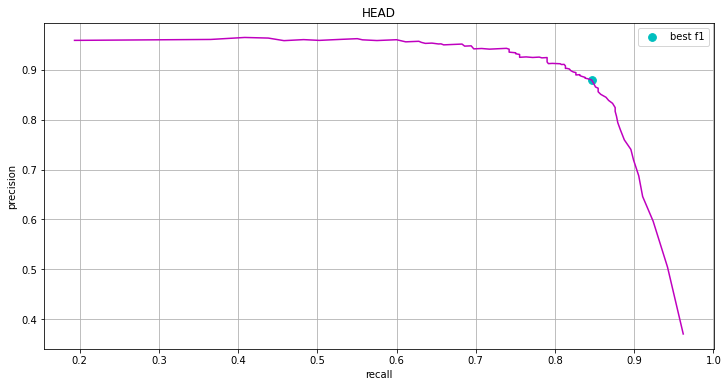

best confidence treshhold = 0.23, with precision = 0.880, recall = 0.846, f1 = 0.863


  0%|          | 0/100 [00:00<?, ?it/s]

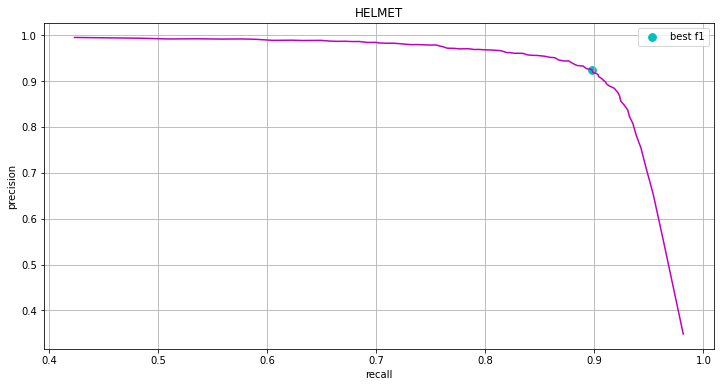

best confidence treshhold = 0.28, with precision = 0.925, recall = 0.898, f1 = 0.911
evaluating model on dataset VAL dataset:
HEAD AP = 0.698
HELMET AP = 0.526
mAP = 0.612


In [57]:
checkpoint = '../drive/MyDrive/datasets/saves/latest.pth'
model = init_detector(cfg, checkpoint, device='cuda:0')
evaluate_model(model, 'data/archive/val/images', 'data/archive/val/output.json', 'VAL dataset')

### Метрики на val датасете с iou treshhold = 0.75

  0%|          | 0/100 [00:00<?, ?it/s]

best confidence treshhold = 0.51, with precision = 0.758, recall = 0.636, f1 = 0.692


  0%|          | 0/100 [00:00<?, ?it/s]

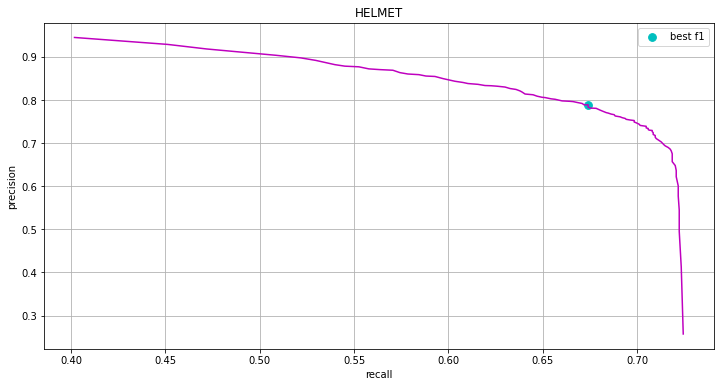

best confidence treshhold = 0.54, with precision = 0.789, recall = 0.674, f1 = 0.727
evaluating model on dataset VAL dataset:
HEAD AP = 0.429
HELMET AP = 0.276
mAP = 0.353


In [ ]:
evaluate_model(model, 'data/archive/val/images', 'data/archive/val/output.json', 'VAL dataset', iou_tresh=0.75)

### Метрики на test датасете с iou treshhold = 0.5

In [58]:
evaluate_model(model, 'data/archive/test/images', 'data/archive/test/output.json', 'TEST dataset')

  0%|          | 0/100 [00:00<?, ?it/s]

best confidence treshhold = 0.19, with precision = 0.835, recall = 0.848, f1 = 0.842


  0%|          | 0/100 [00:00<?, ?it/s]

best confidence treshhold = 0.21, with precision = 0.883, recall = 0.884, f1 = 0.884
evaluating model on dataset TEST dataset:
HEAD AP = 0.646
HELMET AP = 0.482
mAP = 0.564


<font size = 4>Как видим, полученная метрика mAP(iou=50) практически идеально совпадает с метрикой, полученной при автоматической валидации фреймворка. mAP(iou=75) также отличается не сильно(0.35 против 0.42), что может являться результатом разных методов подсчёта площади под PR-кривой а также разным количеством оцениваемых порогов confidence. 

 # 7). Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо
 
В этом пункте нужно подумать, как эта модель может быть использована в дальнейшем. То есть, например, зачем нужно детектировать фрукты? Или одежду?

> Результат пункта $-$ перечисленные кейсы использования модели (описанные **как можно подробнее**).

* Свою модель я предлагаю использовать на любом производстве или стройке, где предъявляются высокие требования к безопасности рабочих, а именно, к ношению касок.
* Модель умеет распознавать голову без каски, как метку "head", и голову в каске, как метку "helmet". Объекты разных классов обводятся в прямоугольники разных цветов, рядом с которыми есть подписи класса и уверенности предсказания
* Как было показано, модель умеет работать с видео, поэтому она может "сотрудничать" с любой камерой видеонаблюдения.
* Из дополнительного стоит добавить лог о времени наблюдения головы без каски, а также запись данного фрагмента видео, для повторной проверки человеком.

<h2 style="text-align: center;"><b>Критерии оценивания</b></h2>

* 1 пункт $-$ 1 балл 
* 2 пункт $-$ 1 балл 
* 3 пункт $-$ 0 баллов (промежуточный пункт)  
* 4 пункт $-$ 3 балла   
* 5 пункт $-$ 3 балла   
* 6 пункт $-$ 1 балл 
* 7 пункт $-$ 1 балл 
* Максимум баллов по проекту $-$ 10  